In [1]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import dgl
from GraphSage import GraphSageNet
import time
import os
import wandb
import time
from tqdm import tqdm
import argparse
import yaml
import sys
sys.path.append('../preprocessing')


from utils import *
# from mit_semseg.utils import AverageMeter, colorEncode, accuracy, intersectionAndUnion
import glob
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from skimage.io import imread
# import sys
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imsave
import os
import torch
warnings.filterwarnings(action='ignore')
from dgl.data.utils import load_graphs
from UAVidToolKit.colorTransformer import UAVidColorTransformer

class Tester(object):
    def __init__(self, config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        config['device'] = self.device
        self.batch_size = config['training']['batch_size']
        self.train_id =  config['test']['train_id']
        
        self.model_path = os.path.join(config['test']['ckpt_dir'] ,'ckpt_'+str(self.train_id),config['test']['ckpt_file'])
        self.save_dir = os.path.join(config['test']['save_result_dir']);   os.makedirs(self.save_dir, exist_ok = True)
        
        self.n_class = config['training']['n_classes']
        self.sampler = config['sampler']['sampler_true']
        self.sampler_neighbor = config['sampler']['sampler_neighbor']
        
        
        # multi_scale mode
        self.multi_scale = config['multi_scale_mode']['use_multi_scale']
        if self.sampler : 
            self.model = GraphSageNet_sampler(config).to(self.device)
        elif self.multi_scale : 
            self.model = GraphMultiNet(config).to(self.device)
        else : 
            self.model = GraphSageNet(config).to(self.device)
        
        self.result_name = 'result'+'_'+str(self.train_id)
        
        
    def test(self):
        self.model.load_state_dict(torch.load(self.model_path,map_location=self.device),strict=False)
        self.model.eval()
        torch.cuda.empty_cache()
        print('dataloading...')
        
        self.raw_data = pd.read_pickle(os.path.join(self.config['data']['pickle_dir'], self.config['test']['test_pickle_name']))  
        with torch.no_grad(): 
            
            
            print('Test...')
            test_acc = []
            save_test_result = []
            
            for idx, row in tqdm(self.raw_data.iterrows()):
                spixel= row['superpixel_segment']
                
                id_path = row['id']
                gt_path = id_path.replace('Images','Labels')
                G = row['G']
                feature = row['feature']
                feature[:,:3] = feature[:,:3] / 255 # rgb normalization
                edges = row['edges']
                label_gt = row['label_gt']
                num_nodes = len(label_gt)
                edges_src = torch.tensor(edges[:,0])
                edges_dst = torch.tensor(edges[:,1])
                dgel_graph = dgl.graph((edges_src , edges_dst), num_nodes=num_nodes, idtype=torch.int32)
                dgel_graph.ndata['feat'] = torch.from_numpy(feature)
                dgel_graph.ndata['label'] = torch.from_numpy(np.array(label_gt))
                # dgel_graph = dgl.remove_self_loop(dgel_graph)
                # dgel_graph = dgl.add_self_loop(dgel_graph)
                

                feature_test  = dgel_graph.ndata['feat'].to(self.device)
                label_test = dgel_graph.ndata['label'].to(self.device)
                G_test = dgel_graph.to(self.device)
                output_test = self.model(G_test, feature_test) 
                label_test_onehot = F.one_hot(label_test.to(torch.int64), self.n_class) 
                label_test = torch.max(label_test_onehot, 1)[1]
    
                # calculate accuracy
                
                pred = output_test.argmax(dim=1, keepdim=True)
                 
                # pred = output_test.argmax(dim=1, keepdim=True)
                crr = pred.eq(label_test.view_as(pred)).sum().item()
                acc = crr / len(pred)
                test_acc.append(acc)
                feature_test = feature_test.cpu().numpy()
                label_test = label_test.cpu().numpy()
                
                # output_test = output_test.cpu().numpy()
                # label_test = label_test.cpu().numpy()
                pred = pred.cpu().numpy()
                
                # save_test_result.append([spixel, gt_path, feature_test,label_test,G,output_test,label_gt,pred])
                save_test_result.append([spixel, gt_path, label_test,pred])
            
            print("Graph validation acc : {:.6f}".format( np.mean(test_acc) ))
            pred = pd.DataFrame(save_test_result)
            # df.columns = ['spixel','gt_path','feature_test','label_test','G','output_test','label_gt','pred']
            pred.columns = ['spixel','gt_path','label_test','pred']
            
            print('Save Dataframe...')
            pred.to_pickle(os.path.join(self.save_dir,self.result_name + '.pickle'))
            
            print("Save Images....")
            
            #### eval part
            # num = pred_pickle_path.split('/')[1].split('_')[1].split('.')[0]
            save_path = f'convert_test_set/pred_g2i_{self.train_id}/'
            os.makedirs(save_path,exist_ok=True)
            convert_Graph_to_Image_function(save_path, pred,self.device)
            pred_path = save_path
            
            
            return pred_path
    
def convert_Graph_to_Image_function(save_path, df,device):
    
    for px in tqdm(range(len(df))):
        
        row = df.iloc[px]
        name_path = row['gt_path']
        name = name_path.split('/')
        
        save_name_pred = save_path + name[4] + '_' + name[-1].split('.')[0]
        # print(save_name_pred)
        
        G2_img = np.zeros((row['spixel'].shape[0], row['spixel'].shape[1]))
        

        G2_img = torch.from_numpy(G2_img)
        G2_img = G2_img.to(torch.device(device))
        
        prediction_cl = np.array(row['pred'])
        test_cl = np.array(row['label_test'])
        superpixel_img = np.array(row['spixel'])
        
        node_num = np.amax(superpixel_img)
                           
        prediction_cl = torch.from_numpy(prediction_cl)
        prediction_cl = prediction_cl.to(torch.device(device))
        
        test_cl = torch.from_numpy(test_cl)
        test_cl = test_cl.to(torch.device(device))
    
        superpixel_img = torch.from_numpy(superpixel_img)
        superpixel_img = superpixel_img.to(torch.device(device))

        for ix in range(node_num):
            
            superpixel_cluster = (superpixel_img[:,:] == ix)
            
            
            prediction_superpixel_cluster_node_mapping = torch.multiply(superpixel_cluster, prediction_cl[ix])
            
            
            
            G2_img = torch.add(G2_img, prediction_superpixel_cluster_node_mapping)
            
        
        G2_img = G2_img.cpu().numpy()
        
        
        np.save(save_name_pred, G2_img)

def parse(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
        f.close()
    return config

Using backend: pytorch


In [2]:
now = int(time.time())

config_path = f'yml/train_uav.yaml'
config = parse(config_path)
# os.environ['CUDA_VISIBLE_DEVICES']=str(config['training']['gpu']['id'] )    
os.environ['CUDA_VISIBLE_DEVICES']='3'

try :
    wandb_name = config['test']['wandb_name']
    wandb_names = wandb_name.split('_')
    config['hidden_dim'] = int(wandb_names[4])
    config['out_dim'] = int(wandb_names[5])
    config['Layer'] = int(wandb_names[6])
    config['test']['train_id'] = wandb_names[-1]
    print(f"train id : {config['test']['train_id']}, hidden dim : {config['hidden_dim']}, out_dim : {config['out_dim']} , Layers : {config['Layer']}")
except : 

    print(f"train id : {config['test']['train_id']}")


train id : 1650239833


In [3]:
tester = Tester(config=config)
pred_path = tester.test()

dataloading...
Test...


70it [00:03, 19.17it/s]


validation acc : 0.693498
Save Dataframe...
Save Images....


100%|█████████████████████████████████████████████████████████████████████████████████████████| 70/70 [17:56<00:00, 15.38s/it]


In [4]:
import logging
def get_logger():
    logger_name = "main-logger"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    fmt = "[%(asctime)s %(levelname)s %(filename)s line %(lineno)d %(process)d] %(message)s"
    handler.setFormatter(logging.Formatter(fmt))
    logger.addHandler(handler)
    return logger
logger = get_logger()

In [ ]:

train_id = config['test']['train_id']
pred_path = f'convert_test_set/pred_g2i_{train_id}/'

def evaluation(pred_path,n_class):
    pred_list = glob.glob(pred_path+'/*')
    count = 0
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    jaccard_list = []
    jaccard_per_image = []
    for idx in tqdm(range(len(pred_list))):
        pred_name = pred_list[idx]        
        # uavid_full
        pred_seq = pred_name.split('/')[-1].split('_')[0]
        pred_num = pred_name.split('/')[-1].split('_')[1]
        gt_path = '../data/uavid/uavid_val/'+ pred_seq + '/Labels/' +pred_num
        gt_img = imread(gt_path.replace('npy','png'))
        clrEnc = UAVidColorTransformer()
        gt_img = clrEnc.transform(gt_img, dtype=np.uint8)


        pred = np.load(pred_name)
        intersection , union, target = intersectionAndUnion(pred, gt_img, n_class)
        # jaccard_list.append(intersection/union)
        intersection_meter.update(intersection)
        union_meter.update(union)
        target_meter.update(target)
        accuracy = sum(intersection_meter.val) / (sum(target_meter.val) + 1e-10)
        jaccard_per_image.append([idx,pred_name,accuracy])
        # logger.info('Evaluating {0}/{1} on image {2}, accuracy {3:.4f}.'.format(idx+ 1, len(pred_list), label_name+'.png', accuracy))
        
    iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
    accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
    mIoU = np.mean(iou_class)
    mAcc = np.mean(accuracy_class)
    allAcc = sum(intersection_meter.sum) / (sum(target_meter.sum) + 1e-10)
    jaccard_list.append([mIoU, mAcc, allAcc])
    logger.info('Eval result: mIoU/mAcc/allAcc {:.4f}/{:.4f}/{:.4f}.'.format(mIoU, mAcc, allAcc))
    for i in range(n_class):
        logger.info('Class_{} result: iou/accuracy {:.4f}/{:.4f}'.format(i, iou_class[i], accuracy_class[i]))
        jaccard_list.append([i, iou_class[i], accuracy_class[i]])
    return jaccard_per_image, jaccard_list

img_acc, class_acc = evaluation(pred_path,8)
acc_df = pd.DataFrame(class_acc)
acc_df




100%|█████████████████████████████████████████████████████████████████████████████████████████| 70/70 [01:04<00:00,  1.08it/s]
[2022-04-18 01:07:37,034 INFO 375819225.py line 40 2815] Eval result: mIoU/mAcc/allAcc 0.4041/0.5504/0.7003.
[2022-04-18 01:07:37,035 INFO 375819225.py line 42 2815] Class_0 result: iou/accuracy 0.3589/0.5201
[2022-04-18 01:07:37,036 INFO 375819225.py line 42 2815] Class_1 result: iou/accuracy 0.6804/0.8305
[2022-04-18 01:07:37,037 INFO 375819225.py line 42 2815] Class_2 result: iou/accuracy 0.5445/0.7732
[2022-04-18 01:07:37,038 INFO 375819225.py line 42 2815] Class_3 result: iou/accuracy 0.2432/0.4031
[2022-04-18 01:07:37,039 INFO 375819225.py line 42 2815] Class_4 result: iou/accuracy 0.5411/0.6728
[2022-04-18 01:07:37,039 INFO 375819225.py line 42 2815] Class_5 result: iou/accuracy 0.4844/0.6251
[2022-04-18 01:07:37,040 INFO 375819225.py line 42 2815] Class_6 result: iou/accuracy 0.0216/0.0219
[2022-04-18 01:07:37,041 INFO 375819225.py line 42 2815] Class_7

,0,1,2
0,0.404136,0.550416,0.700327
1,0.000000,0.358919,0.520086
2,1.000000,0.680361,0.830516
3,2.000000,0.544536,0.773175
4,3.000000,0.243154,0.403102
5,4.000000,0.541106,0.672759
6,5.000000,0.484436,0.625101
7,6.000000,0.021581,0.021945
8,7.000000,0.358999,0.556645


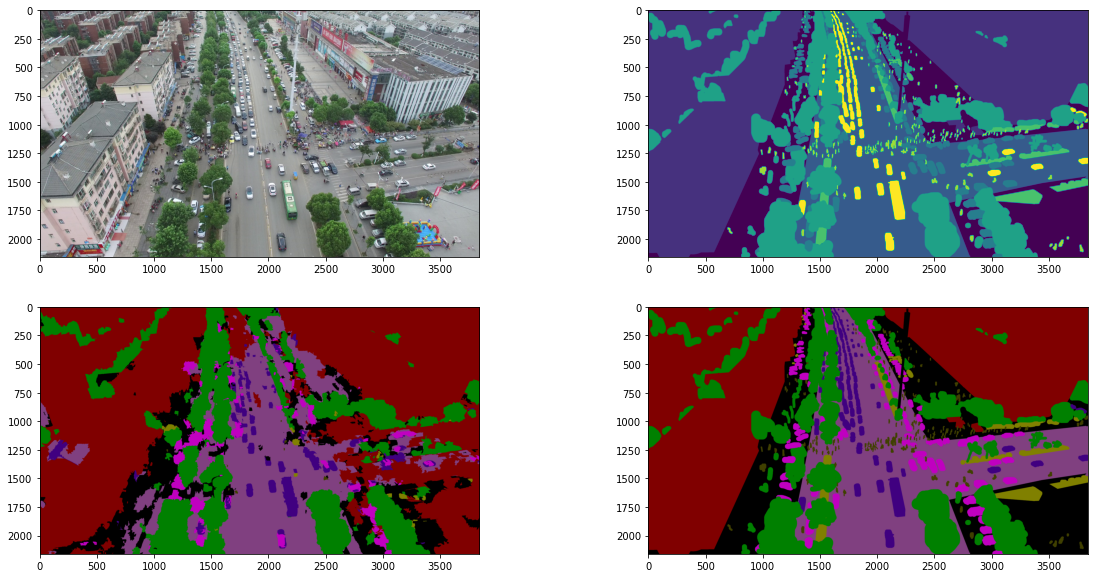

In [18]:
import matplotlib.pyplot as plt
from skimage.io import imshow

from random import *
pred_list = glob.glob(pred_path+'/*')
i = randint(1, len(pred_list)) 
# i=0
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,2)
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
pred_img_path = pred_list[i]
clrEnc = UAVidColorTransformer()
pred_img = np.load(pred_img_path)
# uavid full
pred_seq = pred_img_path.split('/')[-1].split('_')[0]
pred_num = pred_img_path.split('/')[-1].split('_')[1]
gt_path = '../data/uavid/uavid_val/'+ pred_seq + '/Labels/' + pred_num

gt_img = imread(gt_path.replace('npy','png'))
gt_img = clrEnc.transform(gt_img, dtype=np.uint8)
pred_img = clrEnc.inverse_transform(pred_img)
img_path = gt_path.replace('Labels','Images').replace('npy','png')
img = imread(img_path)
color_label = imread(gt_path.replace('npy','png'))

ax0.imshow(img)
ax1.imshow(gt_img)
ax2.imshow(pred_img)
ax3.imshow(color_label)

plt.show()

